# Convolutional Neural Network - Waste Management

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import os

### Data Preprocessing

In [4]:
DIR = 'data'
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))

classes = train_dataset.class_names
num_classes = len(classes)
print(classes)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 6059 files belonging to 6 classes.
Using 5454 files for training.
Found 6059 files belonging to 6 classes.
Using 605 files for validation.
['cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic']


### Model Definition and Training

In [ ]:
baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256, 3), weights='imagenet', include_top=False, classes=num_classes)
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45)(last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045), kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45)(x)
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

learning_rate = 0.00125

model = tf.keras.Model(inputs=baseModel.input, outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 50

lrCallback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1E-3*10**(epoch / 30))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1*0.1**math.floor(epoch/6))
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[])

### Saving the Model

In [ ]:
model.save("/content/model.h5")

### Model Loss

In [ ]:
plt.figure()
plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('results/loss.png')

### Model Accuracy

In [ ]:
plt.figure()
plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('results/accuracy.png')

### Learning Rate vs Loss

In [ ]:
plt.figure()
plt.xlim([0, 0.003])
learning_rates = 1e-3*(10**(np.arange(epochs)/30))
plt.plot(learning_rates, history.history['loss'])
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.tight_layout()
plt.savefig('results/loss_vs_learning_rate.png')

### Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = (np.trace(cm) / float(np.sum(cm)))*100
    misclass = 100 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Greens')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.grid(None)
    plt.tight_layout()
    plt.savefig('results/confusion_matrix.png')

plt.figure(figsize=(10, 10))
true = []
predictions = []

path = "data"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath):
    fullPath = os.path.join(folderPath, j)
    img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) 
    preds = model.predict(img_array)
    true.append(classes.index(i))
    predictions.append(np.argmax(preds))

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)

### Image Prediction

1/1 [==============================] - 5s 5s/step
[9.997e+01 0.000e+00 0.000e+00 0.000e+00 3.000e-02 0.000e+00] 
 ['cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic']
Prediction:  cardboard 99.96622800827026%


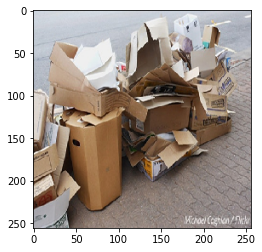

In [13]:
model = tf.keras.models.load_model('model.h5')

path = 'results/prediction.jpg'

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

plt.imshow(img)
print(f"{(predictions[0]*100).round(2)}", "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")